BAIT 508 Group Project: Industry Analysis

PROJECT OVERVIEW: 
The goal of this project is to conduct an in-depth analysis of public US firms within selected industry sector(s) using various data analyses and natural language processing (NLP) techniques that we learned in BAIT 508. Each team will choose at least one industry sector to investigate and utilize multiple datasets to extract valuable industry insights from the data.

The project will utilize three datasets (located in the data folder):
•	public_firms.csv
•	major_groups.csv
•	2020_10K_item1_full.csv

In [1]:
#In this part we downloaded all the packages we need for the project and read the files provided for us.
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import seaborn as sns
import matplotlib.style as style
import string
from DocumentSimilarity import DocumentSimilarity
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading the csv files using the read_cvs() method.
filepath_data= r'data/'
public_firms=pd.read_csv(filepath_data+'public_firms.csv')
twenty20_10K_item1_full=pd.read_csv(filepath_data+'2020_10K_item1_full.csv')
#major_groups =pd.read_csv(filepath_data+'major_groups.csv')

Part 1. Quantitative Analysis of the Industry Sector

A.	[Industry Sector Selection and Data Filtering; 20 points] 

1.	The file "data/major_groups.csv" contains a list of major industry sectors and their corresponding codes (column "major_group"). Your first task is to choose at least one industry sector that interests your group. It is okay if multiple groups choose the same industry sector, so you don’t need to coordinate with other groups.


We used unique function to get the unique values and len to calculated the total numbers for the next 3 questions.

In [3]:
#We selected the Wholesale industry. Its major group numbers are 50 and 51, representing wholesale for durable goods and non-durable goods.
#We chose the wholesale industry because it provides people with what we need in our daily.
wholesale = ( '50','51') #Wholesale


2.	Next, filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected. You can use the "major_group" value, which corresponds to the first two digits of each firm’s SIC code,  to identify relevant firms. For example, if you are interested in the “Business Service” sector and its "major_group" code is 73, you should retain all firms whose SIC codes start with 73. 

In [4]:
#Using the "major_group" value,we selected the firms with SIC code which starts with ‘50’ or ‘51’ . 
#In order to compare the first two numbers of SIC with the major group member efficiently,
#we transformed the type of SIC from integer to string so that we can use str.startswith()
#in string to do the operation

industries_wholesale = public_firms[public_firms['sic'].astype(str).str.startswith(wholesale)]
fname_industries = industries_wholesale

3.	Now, answer the following questions based on the filtered dataset: 

a.	How many unique firm-year ("fyear") observations are there in the filtered dataset?


In [5]:
#We selected the unique values in ‘fyear’ column using unique() and use len() to calculate the total number of unique values. 
unique_fyear=len(fname_industries['fyear'].unique())
unique_fyear

27

b.	How many unique firms are there in the filtered dataset?



In [6]:
#The same way we did with the unique year. Using unique() to find the unique value and len() to calculate the number.
unique_firms = len(fname_industries['conm'].unique())
unique_firms

640

c.	How many firms in the filtered dataset have records over all 27 years (1994-2020)?

In [7]:
#First step: Filter the data to the get companies with 27 years of records. 
#we use filter to get the data of the companies that has 27 years of records.
filtered_firms = fname_industries.groupby('conm').filter(lambda x: len(x) == unique_fyear)
#Second step: Calculated the total number of firms.We use len() and unique() to calculate the unique values
num_firms = len(filtered_firms['conm'].unique())
num_firms

11

B.	[Preliminary Analysis; 20 points] Answer the following questions:

1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?


Step 1: Rank the dataframe with ‘fyear’ 2020  according to ‘prcc_c’ column and find the top ten rows
Step 2: Select the company names


In [8]:
#For step 1, we first do the ranking by using sort_values. 
#Then we selected only the data in year 2020. We use head to find the top 10.
top_ten_stocks = fname_industries.sort_values('prcc_c', ascending=False).loc[fname_industries['fyear'] == 2020].head(10)
#For step 2, we use column selection in the dataframe.
top_ten_stocks[['conm','prcc_c']]

,conm,prcc_c
17053,GRAINGER (W W) INC,408.340
120862,POOL CORP,372.500
26157,MITSUI & CO LTD,366.023
42140,WATSCO INC,226.550
24707,MCKESSON CORP,173.920
90303,SITEONE LANDSCAPE SUPPLY INC,158.630
95925,CDW CORP,131.790
104051,COPART INC,127.250
107901,RELIANCE STEEL & ALUMINUM CO,119.750
119266,AMCON DISTRIBUTING CO,118.950


2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?

The tricky part here is that we need to calculate the sum of the sales for each company first. Otherwise, for every company, there are multiple records and the ranking will not be working as we expect.

we use groupby and sum to calculate the sum of sales for each individual company. Then we used sort_values to rank according to the sum of sales. We assign this processed data to the variable  top_10_firms. 


In [9]:
top_10_firm = fname_industries.groupby('conm').sum(numeric_only=True).sort_values('sale', ascending=False).head(10)
top_10_firm[['sale']]


,sale
conm,
MCKESSON CORP,2876380.400
MITSUI & CO LTD,2076384.551
CARDINAL HEALTH INC,2043256.797
AMERISOURCEBERGEN CORP,1954792.103
SYSCO CORP,900989.228
INGRAM MICRO INC,613663.628
SUPERVALU INC,563953.937
TECH DATA CORP,542110.884
CHS INC,530901.755


3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations. 

Because each company has multiple records, if we were to get the number of companies for each location directly, we would count some companies' names multiple times. To avoid this, we use nunique() to make sure we only count one company once. Finally we used sort_values to rank the number of companies for each location.

In [10]:
unique_locations = fname_industries.groupby('location')['conm'].nunique().sort_values(ascending=False)
unique_locations.head(10)

location
USA    575
CHN     22
HKG     10
GBR      7
CAN      4
ISR      4
BRA      2
ARE      2
JPN      2
MEX      1
Name: conm, dtype: int64

4.	Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.


/tmp/ipykernel_218/1843644440.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_prcc_c_50 = fname_industries[public_firms['sic'].astype(str).str.startswith(wholesale[0])].groupby(['fyear'])['prcc_c'].mean()
/tmp/ipykernel_218/1843644440.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_prcc_c_51 = fname_industries[public_firms['sic'].astype(str).str.startswith(wholesale[1])].groupby(['fyear'])['prcc_c'].mean()


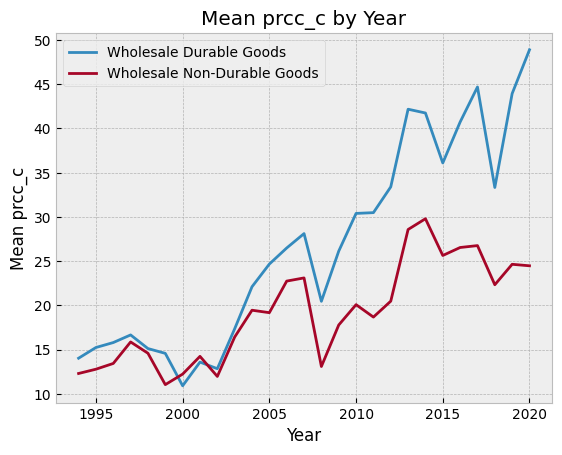

In [11]:
#For each year (Using groupby), we calculated the mean of the stock price (‘prcc_c’) for the whole industry which
#is divided into durable and non-durable goods.
mean_prcc_c_50 = fname_industries[public_firms['sic'].astype(str).str.startswith(wholesale[0])].groupby(['fyear'])['prcc_c'].mean()
mean_prcc_c_51 = fname_industries[public_firms['sic'].astype(str).str.startswith(wholesale[1])].groupby(['fyear'])['prcc_c'].mean()
#We chose the graph style of 'bmh' for the line chart.
style.use('bmh')
#we then use the matplotlib.plot to draw the line chart, specifying the x and y variable in the brackets.
plt.plot(mean_prcc_c_50.index, mean_prcc_c_50.values)
plt.plot(mean_prcc_c_51.index, mean_prcc_c_51.values)
# for better presentation, we label the x axis and y axis. Also, we give the line chart a title of 'Mean prcc_c by Year'.
plt.xlabel('Year')
plt.ylabel('Mean prcc_c') 
plt.title('Mean prcc_c by Year')
plt.legend(['Wholesale Durable Goods','Wholesale Non-Durable Goods'])
plt.show()
#https://stackoverflow.com/questions/63319572/plotting-two-columns-based-on-multiple-variables-in-another-column
#Helpful to plot prcc_c for different industry

5.	Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?

In [12]:
#We first selected the data for 2007 and 2008 seperately for later use using column selection.
prcc_c_2008 = fname_industries[fname_industries['fyear'] == 2008]
prcc_c_2007 = fname_industries[fname_industries['fyear'] == 2007]
#We then merge the two dataframes using 'gkey'. Merging makes it easier for us to do the calculation later.
prcc_merged = prcc_c_2008.merge(prcc_c_2007,
                 how='outer', suffixes=('_x', '_y'), on = 'gvkey')
#Because the column names are not clear, we rename the columns so that it is easier to understand and call.
prcc_merged.rename(columns={'prcc_c_x': 'prccc2008', 'prcc_c_y': 'prccc2007','location_x':'location','conm_x':'conm'}, inplace=True)
#there are some data that we don't need. We use drop() to drop the columns we don't want.
prcc_merged.drop(prcc_merged.filter(regex=('_'),).columns, axis=1, inplace=True)
#clean the NaN value
prcc_merged.dropna(inplace=True)
# We change the name again so that it is more clear.
prcc_merged.rename(columns={'prccc2008': 'prcc_c_2008', 'prccc2007': 'prcc_c_2007'}, inplace=True)
#Finally we do the calculation using the equation:(price of 2008-price of 2007)/price of 2007
prcc_merged['prcc_c_drop'] = (prcc_merged['prcc_c_2008'] - prcc_merged['prcc_c_2007'])*100/prcc_merged['prcc_c_2007']
#We rank the values of the change rate.
prcc_merged.sort_values('prcc_c_drop', inplace=True)
#we want to drop the old index and change it to integer by default.
prcc_merged.reset_index(drop=True,inplace=True)
#use iloc to find the row whose index is 0.
most_affected_firm = prcc_merged.iloc[[0]]
most_affected_firm
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
#Initially used to drop duplicates but code didn't work as expected

,gvkey,location,conm,prcc_c_2008,prcc_c_2007,prcc_c_drop
0,121840,USA,GEORGE FOREMAN ENTERPRISES,0.045,3.5,-98.714286


6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.

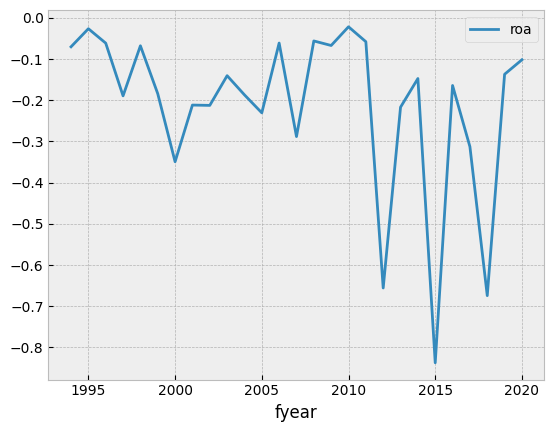

In [13]:
# we don't want to make changes to the original data so we used copy to get a copy of the data and did our calculation on this data copy.
fname_industries_roa = fname_industries.copy()
#This the calculation of roa using the fomula you provided for us.
fname_industries_roa['roa'] = fname_industries['ni'] / fname_industries['asset']
#we first select the data whose location is USA. 
#Then,for each year( using grouby),we calculate the mean of the roa value. 
#Last, we use plot to draw a graph.
usa_roa_yearly_mean_plot = fname_industries_roa[fname_industries_roa['location'] == 'USA'].groupby('fyear')['roa'].mean().plot(legend=True)

Part 2. Text Analysis on the Industry Sector

C.	[Text Cleaning; 10 points] The file "data/2020_10K_item1_full.csv" contains a sample of 5,988 firms and their “item 1” content in their 10-K reports in the year 2020.  Load the dataset as a DataFrame and create a new column containing the cleaned text for each “item1” content. Follow the steps below to clean the text:

1.	Convert all words to lowercase.


In [14]:
#We don't want to make changes to the orginal data so we use copy to create a copy.
twenty20_10K_item1_clean = twenty20_10K_item1_full.copy()
#use str.lower()to lower the case of letters in column['item_1_text']
twenty20_10K_item1_clean['item_1_text'] = twenty20_10K_item1_full['item_1_text'].str.lower()
twenty20_10K_item1_clean.head(5)

,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"general hurco companies, inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",we have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,corporate history chun can capital group (form...,153614
4,1191334,2020,Chun Can Capital Group,corporate history chun can capital group (form...,153614


2.	Remove punctuations.

3.	Remove stop words based on the list of English stop words in NLTK.

In [15]:
#define clean_text function to lowercase all text, remove punctuations, and stopwords
#using str.maketrans to create a translator for removing punctuation
translator = str.maketrans('', '', string.punctuation)
#get a list of English stopwords
sw = stopwords.words('english')
def clean_text(text):
    #convert text to lowercase
    clean_text = text.lower()
    #remove punctuation
    clean_text = clean_text.translate(translator)
    #remove stopwords and create a list of clean words
    clean_words = [w for w in clean_text.split() if w not in sw]
    return ' '.join(clean_words)


In [16]:
# We apply the function to the file to clean the text data.
try:
    twenty20_10K_item1_clean = pd.read_csv(filepath_data+'twenty20_10K_item1_clean.csv')
except:
    twenty20_10K_item1_clean['item_1_clean'] = twenty20_10K_item1_clean['item_1_text'].apply(clean_text).reset_index(drop=True)
    twenty20_10K_item1_clean.drop(['name'],axis = 1,inplace=True)
    twenty20_10K_item1_clean.to_csv(filepath_data+'twenty20_10K_item1_clean.csv',index=False)  
  
twenty20_10K_item1_clean.head(5)

,cik,year,item_1_text,gvkey,item_1_clean
0,1041588,2020,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,"general hurco companies, inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,we have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,corporate history chun can capital group (form...,153614,corporate history chun capital group formerly ...
4,1191334,2020,corporate history chun can capital group (form...,153614,corporate history chun capital group formerly ...


D.	[Keyword Analysis; 20 points] Conduct keywords analysis on your selected industry sector(s). Follow the steps below to complete the analysis:

1.	Create a new DataFrame that includes only firms in your selected industry sectors. Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.


In [17]:
public_firms_2020 = fname_industries[fname_industries['fyear'] == 2020]
#merge the two dataframes using an inner join.
merged_pf_i1_2020 = public_firms_2020.merge(twenty20_10K_item1_clean, how='inner', on='gvkey')


2.	Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.

In [18]:
# We used the functions taught in class to get the top 10 keywords using wordcount and TF-IDF methods.
def get_keywords_wc_top10(text):
    c = Counter(text.lower().split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join([x[0] for x in c.most_common(10)])

def get_keywords_tfidf_top10(document_list):
    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)
    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    return top_keywords

# Created new columns with the top 10 keywords applying the get_keywords_wc_top10 and get_keywords_tfidf_top10
# functions to each row.
merged_pf_i1_2020['keyword_wc_top10'] = merged_pf_i1_2020.item_1_clean.apply(get_keywords_wc_top10)
merged_pf_i1_2020['keyword_tfidf_top10'] = get_keywords_tfidf_top10(merged_pf_i1_2020.item_1_clean.tolist())

# Save the results
merged_pf_i1_2020.to_csv(filepath_data+'merged_pf_i1_2020.csv',index=False)
merged_pf_i1_2020.head(5)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,cik,year,item_1_text,item_1_clean,keyword_wc_top10,keyword_tfidf_top10
0,1004,2020,USA,AAR CORP,1988/01/01,5080,36.22,51.800,35.800,1539.700,1651.400,0.023251,1750,2020,our business we are the largest producer and d...,business largest producer distributor shell eg...,eggs shell egg production us customers special...,eggs egg shell cagefree production feed conven...
1,1121,2020,USA,ADAMS RESOURCES & ENERGY INC,NaN,5172,24.10,39.293,0.995,296.187,1022.422,0.003359,2178,2020,general central valley community bancorp is a ...,general central valley community bancorp bank ...,bank capital banking financial company federal...,bank banking fdic reserve loans capital instit...
2,1659,2020,USA,ANDERSONS INC,NaN,5150,24.51,29.123,7.710,4272.121,8208.436,0.001805,821026,2020,"company overview the andersons, inc. (the com...",company overview andersons inc company diversi...,company grain group commodities ethanol commod...,grain company ethanol commodities commodity fu...
3,1773,2020,USA,ARROW ELECTRONICS INC,NaN,5065,97.30,373.615,584.438,17053.911,28673.363,0.034270,7536,2020,"arrow electronics, inc. (the company or arr...",arrow electronics inc company arrow global pro...,company global business president chief vice c...,company ecs president vice arrow global chief ...
4,1919,2020,USA,AVNET INC,NaN,5065,35.11,477.038,-31.081,8105.197,17634.333,-0.003835,8858,2020,"background caci international inc (caci), a de...",background caci international inc caci delawar...,business caci government operations technology...,caci mission business government enterprise in...


3.	Create two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.

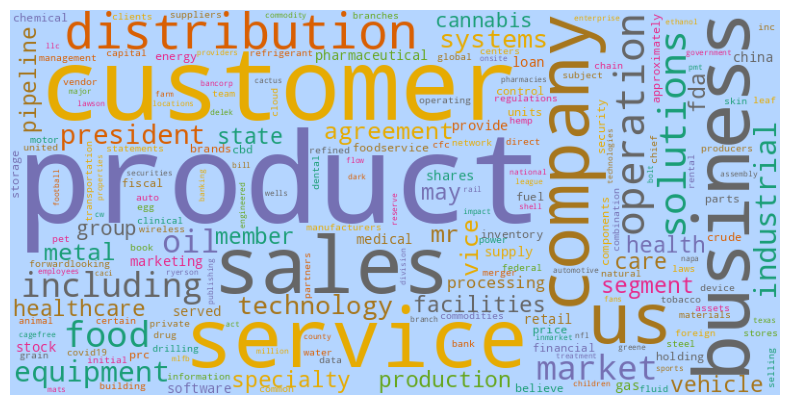

In [19]:
#generating the wordcloud use WordCloud().generate().We picked the background_color and colormap that meet our aesthetic
wordcloud_wc = WordCloud(width=800, height=400,background_color='#b4d5FF',colormap='Dark2', max_font_size=130).generate(' '.join(merged_pf_i1_2020.keyword_wc_top10.tolist()))
plt.figure(figsize=(10,5))
#This line displays the word cloud on the Matplotlib figure using the imshow function.
plt.imshow(wordcloud_wc)
#This line saves the word cloud as an image with the filename 'keyword_wc.png' in the specified file path (filepath_data).
plt.savefig(filepath_data+'keyword_wc.png')
#turns off the axis labels and ticks in the Matplotlib plot
plt.axis('off')
plt.show()

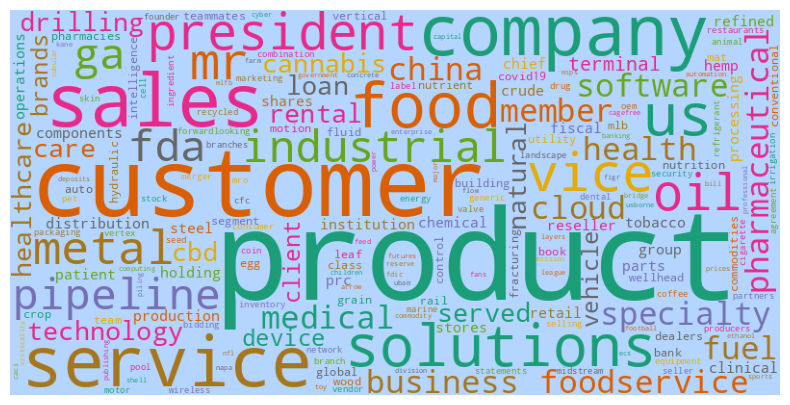

In [20]:
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='#b4d5FF',colormap='Dark2', max_font_size=130).generate(' '.join(merged_pf_i1_2020.keyword_tfidf_top10.tolist()))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_tfidf)
plt.savefig(filepath_data+'keyword_tfidf.png') # save as PNG file
plt.axis('off')
plt.show()

E.	[Word embedding; 20 points] Train a word2vec model and analyze word similarities.
1.	Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.


In [21]:
# We used the try/except statements to load the model if we previously generated the model to expedite the
# code re-run, otherwise we generate the Word2Vec model
try:
    model = Word2Vec.load(filepath_data+'word2vec.model')
except:
    # We create a list of lists of all the clean words used in our industry, then we used it to train our model.
    sent = [row.split() for row in twenty20_10K_item1_clean['item_1_clean']]
    model = Word2Vec(sent, min_count=1, vector_size=50, workers=3, window=3, sg = 1)
    model.save(filepath_data+'word2vec.model')

2.	Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.

In [22]:
# Created a list of words we want to find related words in our trained model.
words_top10_tfidf = ['reseller','sales','service'] #Related to Wholesale
# We use a for loop to print the related words of our list using the wv.most_similar() method using our keywords
# selection as inputs.
for _ in words_top10_tfidf:
    print(f'Similar words for {_}: {model.wv.most_similar(positive=_)[:5]}')

Similar words for reseller: [('resellers', 0.862078070640564), ('dmrs', 0.8532115817070007), ('dropship', 0.8416308164596558), ('dtr', 0.8379378914833069), ('coselling', 0.8370515704154968)]
Similar words for sales: [('telesales', 0.8223063945770264), ('revenues', 0.8196607828140259), ('marketing', 0.8194724321365356), ('nonadvertising', 0.8169374465942383), ('revenue', 0.8154006600379944)]
Similar words for service: [('aftersale', 0.8628788590431213), ('aftersales', 0.8592079281806946), ('noncable', 0.8251493573188782), ('postsale', 0.8197275996208191), ('services', 0.8196985125541687)]


Part 3. Comprehensive Analysis of One Sample Firm
F.	[Firm Analysis and Strategy Suggestion; 10 points] This is an open question. Pick one firm that you are interested in and try to analyze its market status. The ultimate goal is to provide one valuable suggestion to the firm based on your analysis. Some directions you might consider are, but not limited to:
1.	Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. Add up the embeddings for each firm to create the firm-level embeddings. Use the firm-level embeddings to find the focal firm’s competing firms (or, most similar firms). 


In [23]:
# create DocumentSimilarity instance
dsimilar = DocumentSimilarity(model=model, gvkeys=merged_pf_i1_2020['gvkey'], conm=merged_pf_i1_2020['conm'], keywordslist=merged_pf_i1_2020['keyword_tfidf_top10'])

# get firm with max sales
firm = merged_pf_i1_2020.loc[merged_pf_i1_2020['sale'].idxmax(), 'gvkey']

# get embedding for the firm
dsimilar.get_firm_embedding(firm)

# find top 5 similar firms
most_similar_firms_ = dsimilar.most_similar(firm, topn=5)
most_similar_firms_


[(31673, 'AMERISOURCEBERGEN CORP', 0.96300757),
 (25880, 'PATTERSON COS INC', 0.9392948),
 (8213, 'OWENS & MINOR INC', 0.9286187),
 (61494, 'HENRY SCHEIN INC', 0.8956044),
 (63986, 'EPLUS INC', 0.88034624)]

2.	Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.

In [24]:
# create an empty list to store firm codes
firms = []

# iterate through the most similar firms and add the main firm and similar firm codes
for similar_firm in most_similar_firms_:
    firms += [firm, similar_firm[0]]

# filter the original dataset to get information about the most similar firms
most_similar_firms = merged_pf_i1_2020[merged_pf_i1_2020['gvkey'].isin(firms)].copy()

# create 'revenue' and 'market_share' columns
most_similar_firms['revenue'] = most_similar_firms['sale']
most_similar_firms['market_share'] = most_similar_firms['sale'] / most_similar_firms['sale'].sum()

most_similar_firms

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,cik,year,item_1_text,item_1_clean,keyword_wc_top10,keyword_tfidf_top10,revenue,market_share
16,7171,2020,USA,MCKESSON CORP,NaN,5122,173.92,6278.000,-4539.000,65015.000,238228.000,-0.069815,927653,2020,"general mckesson corporation ( mckesson, the ...",general mckesson corporation mckesson company ...,solutions business services pharmaceutical pro...,mckesson pharmaceutical pharmacies solutions h...,238228.000,0.524498
19,8213,2020,USA,OWENS & MINOR INC,NaN,5047,27.05,83.058,29.871,3335.639,8480.177,0.008955,75252,2020,"general owens & minor, inc. and subsidiaries (...",general owens minor inc subsidiaries us fortun...,products healthcare business us customers serv...,healthcare products halyard surgical medical p...,8480.177,0.018671
46,25880,2020,USA,PATTERSON COS INC,1992/10/28,5047,29.63,143.244,155.981,2751.511,5912.066,0.056689,891024,2020,forward-looking statements the u.s. private se...,forwardlooking statements us private securitie...,health products animal us customers sales patt...,patterson animal dental health products us cus...,5912.066,0.013016
61,31673,2020,USA,AMERISOURCEBERGEN CORP,1995/04/04,5122,97.76,4597.746,-3408.716,44274.830,189893.926,-0.076990,1140859,2020,"as used herein, the terms company, amerisou...",used herein terms company amerisourcebergen us...,pharmaceutical services distribution healthcar...,pharmaceutical healthcare services pharmaceuti...,189893.926,0.418083
79,61494,2020,USA,HENRY SCHEIN INC,1995/11/03,5047,66.86,421.185,403.794,7772.532,10119.141,0.051951,1000228,2020,general we believe we are the world s largest ...,general believe world largest provider health ...,health products care services president us cer...,dental health care president vice practitioner...,10119.141,0.022279
82,63986,2020,USA,EPLUS INC,1996/11/14,5045,87.95,NaN,74.397,1076.775,1568.323,0.069092,1022408,2020,general our company was founded in 1990 and is...,general company founded 1990 delaware corporat...,services customers solutions ● technology eplu...,eplus cloud solutions services customers secur...,1568.323,0.003453


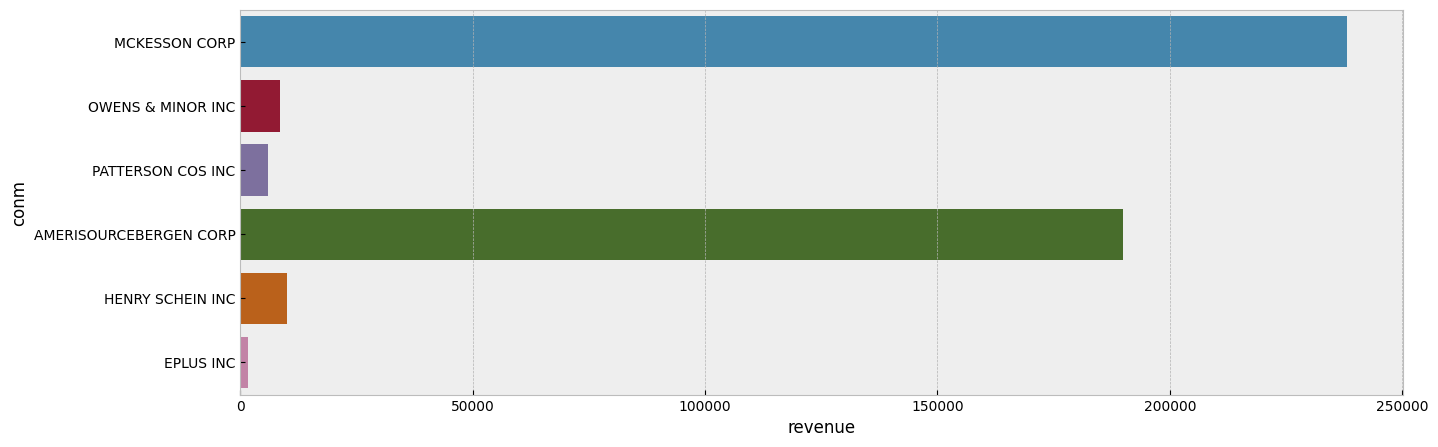

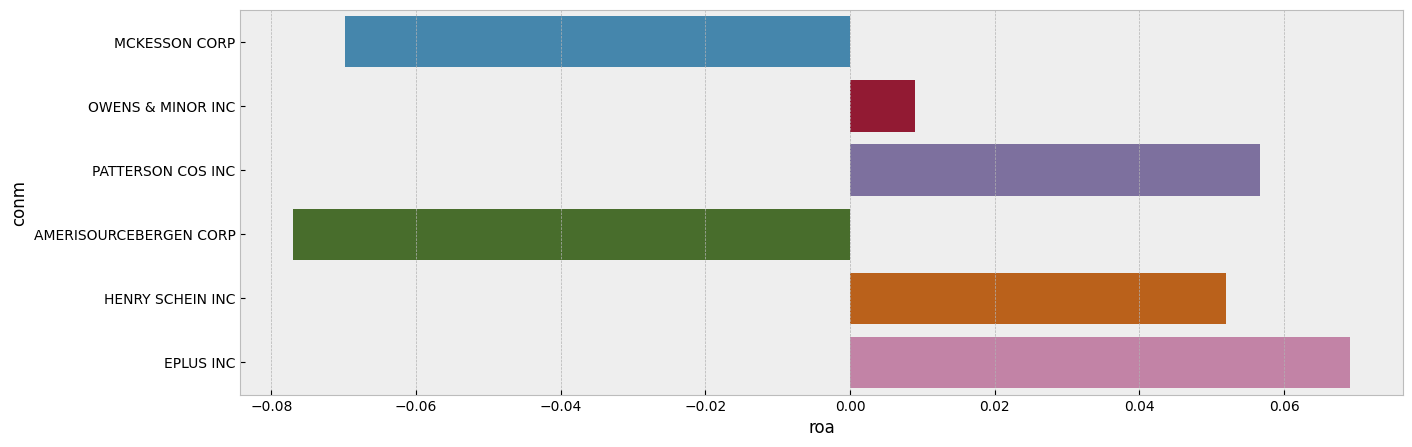

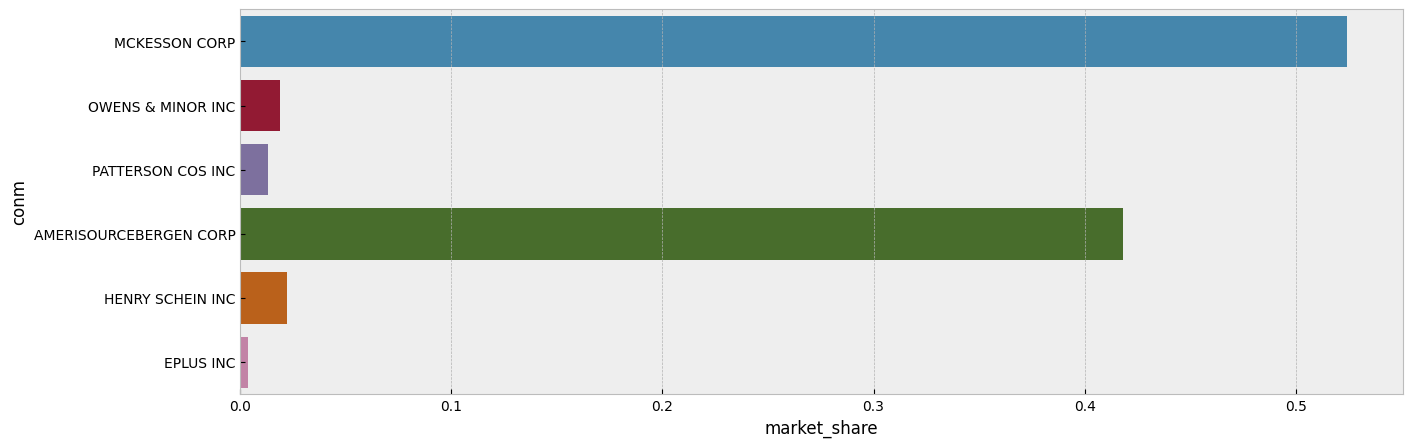

In [25]:
# list of columns to plot
columns_to_plot = ['revenue', 'roa', 'market_share']

# loop through each column and create a bar plot
for col in columns_to_plot:
    plt.figure(figsize=(15, 5))
    # create a bar plot using seaborn
    sns.barplot(x=col, y='conm', data=most_similar_firms)
    plt.savefig(f'imgs\\{col}.png')
    plt.show()


3.	Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen company. Investigate potential correlations and address noteworthy decreases and increases.

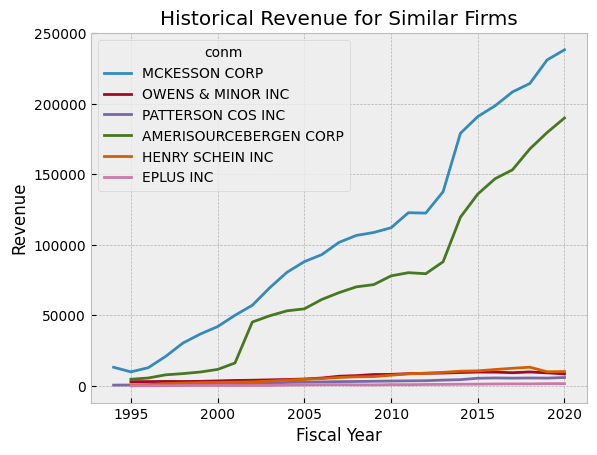

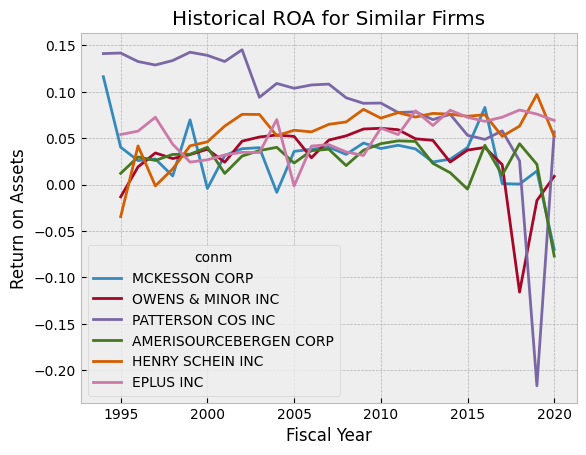

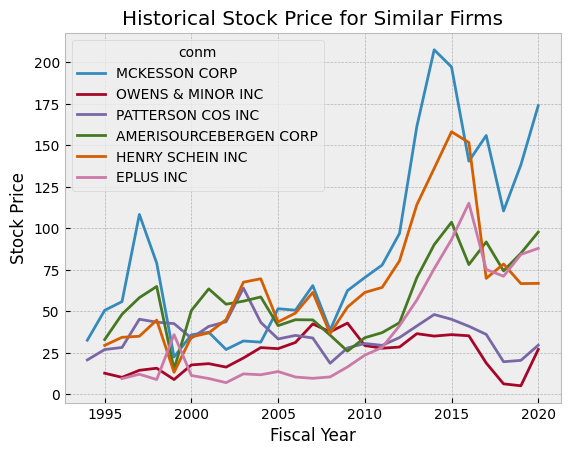

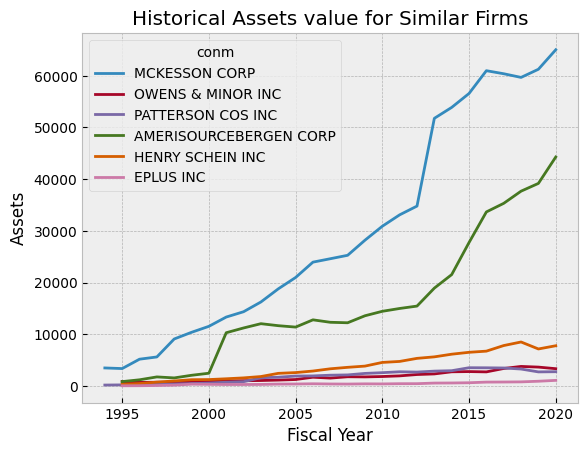

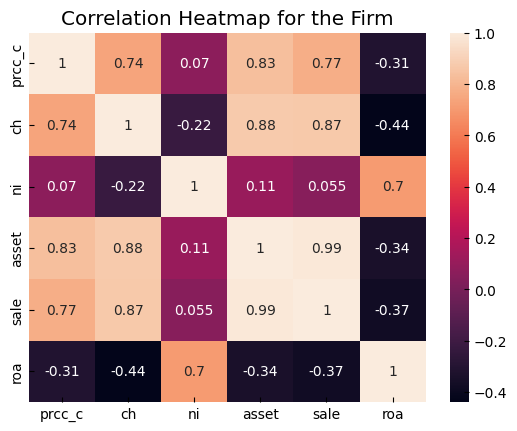

In [26]:
#historical data for the specified firm
historical_data_for_firm = public_firms[public_firms['gvkey'] == firm].copy()

#historical data for all similar firms
historical_data_for_firms = public_firms[public_firms['gvkey'].isin(firms)].copy()

#plot revenue over fiscal years for all similar firms
sns.lineplot(x='fyear', y='sale', hue='conm', data=historical_data_for_firms)
plt.xlabel('Fiscal Year')
plt.ylabel('Revenue')
plt.title('Historical Revenue for Similar Firms')
plt.show()

#plot return on assets over years for all similar firms
sns.lineplot(x='fyear', y='roa', hue='conm', data=historical_data_for_firms)
plt.xlabel('Fiscal Year')
plt.ylabel('Return on Assets')
plt.title('Historical ROA for Similar Firms')
plt.show()

#plot stock price over years for all similar firms
sns.lineplot(x='fyear', y='prcc_c', hue='conm', data=historical_data_for_firms)
plt.xlabel('Fiscal Year')
plt.ylabel('Stock Price')
plt.title('Historical Stock Price for Similar Firms')
plt.show()

#plot assets value over years for all similar firms
sns.lineplot(x='fyear', y='asset', hue='conm', data=historical_data_for_firms)
plt.xlabel('Fiscal Year')
plt.ylabel('Assets')
plt.title('Historical Assets value for Similar Firms')
plt.show()

# create a heatmap showing correlations
sns.heatmap(historical_data_for_firm[['prcc_c', 'ch', 'ni', 'asset', 'sale', 'roa']].corr(), annot=True)
plt.title('Correlation Heatmap for the Firm')
plt.show()
# reference - https://blog.quantinsti.com/creating-heatmap-using-python-seaborn/#:~:text=A%20heatmap%20is%20a%20two,as%20per%20the%20creator's%20requirement.
# to create heatmap with correlation
#referenc - https://seaborn.pydata.org/generated/seaborn.lineplot.html
#to create the lineplots

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3752f254-871a-4bce-92bf-ed9e9266f9cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>